In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
import scipy.stats
import pandas as pd


class GridWorld(gym.Env):
    def __init__(self):
        super(GridWorld, self).__init__()

        self.size = (10, 10)
        self.rewards = {
            (1,1): 2, (3,5): 2, (7,3): 2, 
            (6,6): 3, (8,2): 3,
            (5,8): 5
        }  
        self.pits = [(1,4), (3,6), (7,4)]
        self.walls = [(2,2), (2,4), 
                      (3,4), (3,1), (4,4),(5,2), 
                       (6,7), (7,6), (7,7)]
        self.goal = (9,9)
        self.agent_positions = [(0, 0), (9, 0), (0, 9)]  
        self.total_reward = 0
        self.agent_steps = [0, 0, 0]
        self.max_steps = 20

        self.action_space = spaces.Discrete(4)  

        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.size[0]),
            spaces.Discrete(self.size[1]),
            spaces.Box(low=0, high=np.inf, shape=(1,)),
            spaces.Discrete(self.max_steps+1)
        ))
    def step(self, actions):
        next_states = []
        rewards = []
        dones = []
        local_rewards = [0, 0, 0]  

        for agent_index, action in enumerate(actions):
            x, y = self.agent_positions[agent_index]
            next_x, next_y = x, y  

            if action == 0:   # move up
                next_x = max(0, x-1)
            elif action == 1: # move down
                next_x = min(self.size[0]-1, x+1)
            elif action == 2: # move left
                next_y = max(0, y-1)
            elif action == 3: # move right
                next_y = min(self.size[1]-1, y+1)
            
            if (next_x, next_y) not in self.walls:
                x, y = next_x, next_y
            self.agent_positions[agent_index] = (x, y)

            if (x, y) in self.pits:
                self.total_reward = 0
            else: 
                # Remove reward from dictionary once an agent collects it
                local_rewards[agent_index] += self.rewards.pop((x, y), 0)

            self.agent_steps[agent_index] += 1

            done = (x, y) == self.goal or self.agent_steps[agent_index] == self.max_steps

            if done and (x, y) != self.goal:
                self.total_reward = 0    

            next_states.append(self.agent_positions[agent_index])
            dones.append(done)
        
        self.total_reward += sum(local_rewards)
        rewards = [self.total_reward for _ in actions]  # all agents get the total reward

        # Remove the collected rewards
        for position in self.agent_positions:
            if position in self.rewards:
                del self.rewards[position]

        return next_states, rewards, dones, {}

    def reset(self):
        self.rewards = {
            (1,1): 2, (3,5): 2, (7,3): 2, 
            (6,6): 3, (8,2): 3,
            (5,8): 5
        } 
        self.agent_positions = [(0, 0), (9, 0), (0, 9)]  # Reset the agents to the starting positions
        self.total_reward = 0
        self.agent_steps = [0, 0, 0]
        return self.agent_positions  # return the initial state of the environment



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


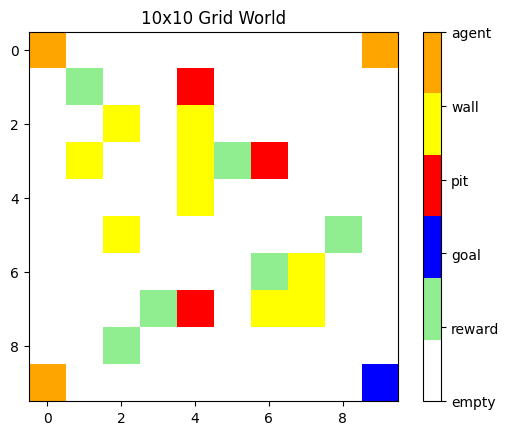

In [2]:


def visualize_grid_world(grid_world):
    size = grid_world.size
    rewards = grid_world.rewards
    pits = grid_world.pits
    walls = grid_world.walls
    goal = grid_world.goal
    agent_positions = grid_world.agent_positions

    # Create a grid to represent the world
    grid = np.zeros(size)
    
    # Mapping for the cell types for color coding
    cell_mapping = {
        'empty': 0,
        'reward': 1,
        'goal': 2,
        'pit': 3,
        'wall': 4,
        'agent': 5
    }
    
    # Create a custom colormap
    colors = ['white', 'lightgreen', 'blue', 'red', 'yellow', 'orange']
    cmap = ListedColormap(colors)

    # Mark the elements on the grid
    for element, positions in zip(['reward', 'pit', 'wall', 'agent'], [rewards, pits, walls, agent_positions]):
        for pos in positions:
            grid[pos] = cell_mapping[element]

    grid[goal] = cell_mapping['goal']

    # Plot the grid
    plt.imshow(grid, cmap=cmap, interpolation='nearest')


    # Add color bar
    colorbar = plt.colorbar(ticks=range(len(colors)))
    colorbar.set_ticklabels(list(cell_mapping.keys()))

    plt.title(f"{size[0]}x{size[1]} Grid World")
    plt.show()

# Create an instance of the GridWorld environment
env = GridWorld()

# Visualize the grid world
visualize_grid_world(env)


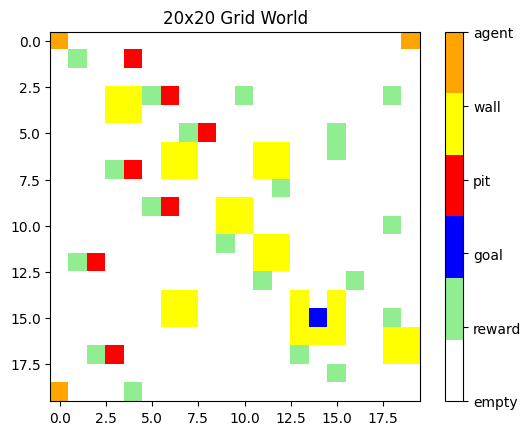

In [3]:

class GridWorld2(gym.Env):
    def __init__(self):
        super(GridWorld2, self).__init__()

        self.size = (20, 20)
        self.rewards = {
            (1,1): 2, (3,5): 2, (5,7): 2, (7,3): 2, 
            (9,5): 2, (12,1): 2, (15,6): 2, (17,2): 2, 
            (19,4): 2, (3,10): 2, 
            (6,15): 3, (8,12): 3, (11,9): 3, (13,11): 3, 
            (17,13): 3, (18,15): 3, (15,18): 3, (13,16): 3,
            (10,18): 5, (5,15): 5, (3,18): 5
        }  
        self.pits = [(1,4), (3,6), (5,8), (7,4), 
                      (9,6), (12,2), (15,7), (17,3)]
        self.walls = [(14,13), (14,15), 
                      (15,13), (15,15), 
                      (16,13), (16,14), (16,15), 
                      (6,6), (6,7), (7,6), (7,7), 
                      (11,11), (11,12), (12,11), (12,12),
                      (3,3), (3,4), (4,3), (4,4), 
                      (6,11), (6,12), (7,11), (7,12), 
                      (9,9), (9,10), (10,9), (10,10),
                      (14,6), (14,7), (15,6), (15,7),
                      (16,18), (16,19), (17,18), (17,19)]
        self.goal = (15,14)
        self.agent_positions = [(0, 0), (19, 0), (0, 19)]  
        self.total_reward = 0
        self.agent_steps = [0, 0, 0]
        self.max_steps = 50

        self.action_space = spaces.Discrete(4)  

        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.size[0]),
            spaces.Discrete(self.size[1]),
            spaces.Box(low=0, high=np.inf, shape=(1,)),
            spaces.Discrete(self.max_steps+1)
        ))

    def step(self, actions):
        next_states = []
        rewards = []
        dones = []
        local_rewards = [0, 0, 0]  # reset local rewards

        for agent_index, action in enumerate(actions):
            x, y = self.agent_positions[agent_index]
            next_x, next_y = x, y  

            if action == 0:   # move up
                next_x = max(0, x-1)
            elif action == 1: # move down
                next_x = min(self.size[0]-1, x+1)
            elif action == 2: # move left
                next_y = max(0, y-1)
            elif action == 3: # move right
                next_y = min(self.size[1]-1, y+1)
            
            if (next_x, next_y) not in self.walls:
                x, y = next_x, next_y
            self.agent_positions[agent_index] = (x, y)

            if (x, y) in self.pits:
                self.total_reward = 0
            else:
                # Remove reward from dictionary once an agent collects it
                local_rewards[agent_index] += self.rewards.pop((x, y), 0)

            self.agent_steps[agent_index] += 1

            done = (x, y) == self.goal or self.agent_steps[agent_index] == self.max_steps

            if done and (x, y) != self.goal:
                self.total_reward = 0    

            next_states.append(self.agent_positions[agent_index])
            dones.append(done)
        
        self.total_reward += sum(local_rewards)
        rewards = [self.total_reward for _ in actions]  # all agents get the total reward
        
        return next_states, rewards, dones, {}

    def reset(self):
        self.rewards = {
            (1,1): 2, (3,5): 2, (5,7): 2, (7,3): 2, 
            (9,5): 2, (12,1): 2, (15,6): 2, (17,2): 2, 
            (19,4): 2, (3,10): 2, 
            (6,15): 3, (8,12): 3, (11,9): 3, (13,11): 3, 
            (17,13): 3, (18,15): 3, (15,18): 3, (13,16): 3,
            (10,18): 5, (5,15): 5, (3,18): 5
        }
        self.agent_positions = [(0, 0), (19, 0), (0, 19)]  # Reset the agents to starting positions
        self.total_reward = 0
        self.agent_steps = [0, 0, 0]
        return self.agent_positions  

env = GridWorld2()

# Visualize the grid world
visualize_grid_world(env)


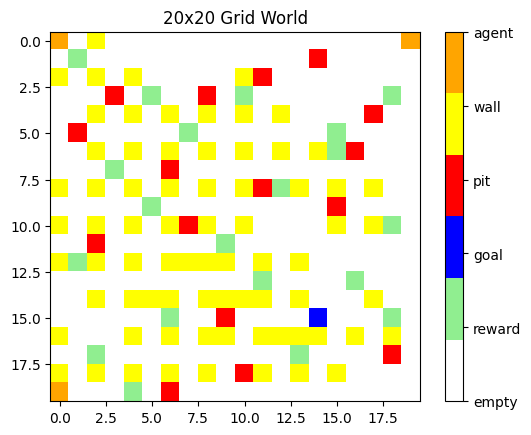

In [4]:


class GridWorld3(gym.Env):
    def __init__(self):
        super(GridWorld3, self).__init__()

        self.size = (20, 20)
        self.rewards = {
            (1,1): 2, (3,5): 2, (5,7): 2, (7,3): 2, 
            (9,5): 2, (12,1): 2, (15,6): 2, (17,2): 2, 
            (19,4): 2, (3,10): 2, 
            (6,15): 3, (8,12): 3, (11,9): 3, (13,11): 3, 
            (17,13): 3, (18,15): 3, (15,18): 3, (13,16): 3,
            (10,18): 5, (5,15): 5, (3,18): 5
        }  
        self.pits = [(3,3), (3,8), (7,6), (8,11), (9,15), 
                     (10,7), (12,13), (15,9), (16,14), (17,18), 
                     (5,1), (6,16), (2,11), (14,8), (11,2), (18,10),
                     (4,17), (16,4), (19,6), (1,14)]
        
        self.walls = [
            (0, 0), (0, 2), (2, 0), (2, 2), (2, 4), (4, 2), (4, 4), (4, 6), (6, 4), (6, 6),
            (6, 8), (8, 6), (8, 8), (8, 10), (10, 8), (10, 10), (6, 2), (8, 0), (8, 2),
            (8, 4), (10, 2), (10, 4), (10, 6), (12, 4), (12, 6), (12, 8), (14, 6), (14, 8),
            (10, 0), (12, 0), (12, 2), (12, 4), (14, 2), (14, 4), (14, 5), (16, 4), (16, 6),
            (16, 8), (18, 6), (18, 8), (16, 0), (18, 0), (18, 2), (18, 4), 
            (18, 2),   (2, 10), (4, 8), (4, 10), (4, 12), (6, 10),
            (6, 12), (6, 14), (8, 13), (8, 15), (8, 17), (10, 15), (10, 17), (10, 10),
            (12, 9), (12, 11), (12, 13), (14, 11), (14, 13), (10, 8), (12, 7), (12, 9),
            (12, 11), (14, 9), (14, 11), (14, 10), (16, 9), (16, 11), (16, 13), (18, 11),
            (18, 13), (16, 12), (18, 11), (18, 13), (18, 15), (16, 14), (18, 13), (18, 15),
            (14, 17), (16, 16), (16, 18)
        ]
        self.goal = (15,14)
        self.agent_positions = [(0, 0), (19, 0), (0, 19)]  
        self.total_reward = 0
        self.agent_steps = [0, 0, 0]
        self.max_steps = 50

        self.action_space = spaces.Discrete(4)  

        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.size[0]),
            spaces.Discrete(self.size[1]),
            spaces.Box(low=0, high=np.inf, shape=(1,)),
            spaces.Discrete(self.max_steps+1)
        ))

    def step(self, actions):
        next_states = []
        rewards = []
        dones = []
        local_rewards = [0, 0, 0]  # reset local rewards

        for agent_index, action in enumerate(actions):
            x, y = self.agent_positions[agent_index]
            next_x, next_y = x, y  

            if action == 0:   # move up
                next_x = max(0, x-1)
            elif action == 1: # move down
                next_x = min(self.size[0]-1, x+1)
            elif action == 2: # move left
                next_y = max(0, y-1)
            elif action == 3: # move right
                next_y = min(self.size[1]-1, y+1)
            
            if (next_x, next_y) not in self.walls:
                x, y = next_x, next_y
            self.agent_positions[agent_index] = (x, y)

            if (x, y) in self.pits:
                self.total_reward = 0
            else:
               # Remove reward from dictionary once an agent collects it
                local_rewards[agent_index] += self.rewards.pop((x, y), 0)

            self.agent_steps[agent_index] += 1

            done = (x, y) == self.goal or self.agent_steps[agent_index] == self.max_steps

            if done and (x, y) != self.goal:
                self.total_reward = 0    

            next_states.append(self.agent_positions[agent_index])
            dones.append(done)
        
        self.total_reward += sum(local_rewards)
        rewards = [self.total_reward for _ in actions]  # all agents get the total reward
        
        return next_states, rewards, dones, {}

    def reset(self):
        self.rewards = {
            (1,1): 2, (3,5): 2, (5,7): 2, (7,3): 2, 
            (9,5): 2, (12,1): 2, (15,6): 2, (17,2): 2, 
            (19,4): 2, (3,10): 2, 
            (6,15): 3, (8,12): 3, (11,9): 3, (13,11): 3, 
            (17,13): 3, (18,15): 3, (15,18): 3, (13,16): 3,
            (10,18): 5, (5,15): 5, (3,18): 5
        }
        self.agent_positions = [(0, 0), (19, 0), (0, 19)]  # Reset the agents to the starting positions
        self.total_reward = 0
        self.agent_steps = [0, 0, 0]
        return self.agent_positions  

env = GridWorld3()

# Visualize the grid world
visualize_grid_world(env)

In [5]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.3, discount_factor=0.95, initial_epsilon=1, epsilon_decay_rate=0.6, epsilon_decay_schedule=1000):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.initial_epsilon = initial_epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.epsilon_decay_schedule = epsilon_decay_schedule
        self.epsilon = self.initial_epsilon
        self.Q_values_table = {}
        self.number_of_possible_actions = env.action_space.n
        self.episode_count = 0
        self.exploration_count = 0
        self.exploitation_count = 0
    
    def initialize_Q_value_if_needed(self, state, action):
        state_action_pair = (state, action)
        if state_action_pair not in self.Q_values_table:
            self.Q_values_table[state_action_pair] = 0.0

    def get_Q_value(self, state, action):
        self.initialize_Q_value_if_needed(state, action)
        return self.Q_values_table[(state, action)]

    def calculate_new_Q_value(self, current_q_value, reward, max_future_q_value):
        return current_q_value + self.learning_rate * (reward + self.discount_factor * max_future_q_value - current_q_value)

    def update_action_value(self, state, action, reward, next_state):
        current_q_value = self.get_Q_value(state, action)
        max_future_q_value = self.find_max_Q_value_for_state(next_state)
        new_q_value = self.calculate_new_Q_value(current_q_value, reward, max_future_q_value)
        self.Q_values_table[(state, action)] = new_q_value

    def find_max_Q_value_for_state(self, state):
        highest_q_value = -np.inf
        for action in range(self.number_of_possible_actions):
            current_q_value = self.get_Q_value(state, action)
            if current_q_value > highest_q_value:
                highest_q_value = current_q_value
        return highest_q_value

    def choose_random_action(self):
        return np.random.choice(self.number_of_possible_actions)

    def find_best_action_for_state(self, state):
        best_action = None
        highest_q_value = -np.inf
        for action in range(self.number_of_possible_actions):
            current_q_value = self.get_Q_value(state, action)
            if current_q_value > highest_q_value:
                highest_q_value = current_q_value
                best_action = action
        return best_action

    def select_action(self, state):
        random_number = np.random.random()
        if random_number < self.epsilon:
            self.exploration_count += 1
            chosen_action = self.choose_random_action()
        else:
            self.exploitation_count += 1
            chosen_action = self.find_best_action_for_state(state)
        return chosen_action

    def apply_epsilon_decay(self):
        self.episode_count += 1
        if self.episode_count % self.epsilon_decay_schedule == 0:
            self.epsilon = max(self.epsilon * self.epsilon_decay_rate, 0.01) # ensuring epsilon does not go to 0


In [6]:

def calculate_statistics(Q_values_table):
    q_values = np.array(list(Q_values_table.values()))
    mean_q_values = np.mean(q_values)
    median_q_values = np.median(q_values)
    mode_q_values = np.argmax(np.bincount(q_values.astype(int)))
    var_q_values = np.var(q_values)
    std_q_values = np.std(q_values)
    q75, q25 = np.percentile(q_values, [75 ,25])
    iqr_q_values = q75 - q25
    skewness_q_values = scipy.stats.skew(q_values)
    kurtosis_q_values = scipy.stats.kurtosis(q_values)

    statistics = {
        "mean": mean_q_values,
        "median": median_q_values,
        "mode": mode_q_values,
        "variance": var_q_values,
        "standard_deviation": std_q_values,
        "interquartile_range": iqr_q_values,
        "skewness": skewness_q_values,
        "kurtosis": kurtosis_q_values
    }

    return statistics

def _run_single_experiment(env, number_of_episodes, agent_class, decay_rate=0.999, learning_rate=0.3, discount_factor=0.95, epsilon_values=[1, 0.5, 0.1]):
    agent_rewards = []
    epsilon_over_time = []
    exploration_over_time = []
    exploitation_over_time = []
    q_values_statistics = []
    agent_q_values = []
    
    for initial_epsilon in epsilon_values:
        agents = [agent_class(env, learning_rate, discount_factor, initial_epsilon) for _ in range(3)]
        total_rewards = []
        average_rewards = []
        epsilon_values = []
        avg_exploration_counts = []
        avg_exploitation_counts = []
        exploration_counts1 = []
        exploitation_counts1 = []
        exploration_counts = []
        exploitation_counts = []

        for episode in range(number_of_episodes):
            # reset the count for the current episode
            for agent in agents:
                agent.exploration_count = 0
                agent.exploitation_count = 0

            state = env.reset()
            done = [False, False, False]
            episode_reward = 0

            while not all(done):
                actions = [agent.select_action(state[i]) for i, agent in enumerate(agents)]
                next_state, reward, done, _ = env.step(actions)

                for i, agent in enumerate(agents):
                    agent.update_action_value(state[i], actions[i], reward[i], next_state[i])

                state = next_state
                episode_reward += sum(reward)

            for agent in agents:
                agent.apply_epsilon_decay()

            total_rewards.append(episode_reward)
            epsilon_values.append(agents[0].epsilon)
            avg_exploration_counts.append(agents[0].exploration_count)
            avg_exploitation_counts.append(agents[0].exploitation_count)

            if episode >= 100:
                average_rewards.append(sum(total_rewards[-100:]) / 300)
            
            if episode >= 100:
               exploration_counts1.append(sum(avg_exploration_counts[-100:]) / 100)
            if episode >= 100:
                exploitation_counts1.append(sum(avg_exploitation_counts[-100:]) / 100)

        agent_q_values.append(agents[0].Q_values_table)
        agent_rewards.append(average_rewards)
        epsilon_over_time.append(epsilon_values)
        exploration_over_time.append(exploration_counts1)
        exploitation_over_time.append(exploitation_counts1)
        stats = calculate_statistics(agents[0].Q_values_table)
        q_values_statistics.append(stats)

    return agent_rewards, epsilon_over_time, exploration_over_time, exploitation_over_time, q_values_statistics, agent_q_values

def train_agents(env, number_of_episodes, agent_class, number_of_runs, decay_rate=0.999, learning_rate=0.3, discount_factor=0.95, epsilon_values=[1, 0.5, 0.1]):
    all_agent_rewards = []
    all_epsilon_over_time = []
    all_exploration_over_time = []
    all_exploitation_over_time = []
    all_q_values_statistics = []
    all_agent_q_values = []

    for run in range(number_of_runs):
        agent_rewards, epsilon_over_time, exploration_over_time, exploitation_over_time, q_values_statistics, agent_q_values = _run_single_experiment(env, number_of_episodes, agent_class, decay_rate, learning_rate, discount_factor, epsilon_values)
        all_agent_rewards.append(agent_rewards)
        all_epsilon_over_time.append(epsilon_over_time)
        all_exploration_over_time.append(exploration_over_time)
        all_exploitation_over_time.append(exploitation_over_time)
        all_q_values_statistics.append(q_values_statistics)
        all_agent_q_values.append(agent_q_values)

    # Convert the lists to numpy arrays
    all_agent_rewards = np.array(all_agent_rewards)
    all_epsilon_over_time = np.array(all_epsilon_over_time)
    all_exploration_over_time = np.array(all_exploration_over_time)
    all_exploitation_over_time = np.array(all_exploitation_over_time)
    # Compute the average across the runs
    avg_agent_rewards = np.mean(all_agent_rewards, axis=0)
    avg_epsilon_over_time = np.mean(all_epsilon_over_time, axis=0)
    avg_exploration_over_time = np.mean(all_exploration_over_time, axis=0)
    avg_exploitation_over_time = np.mean(all_exploitation_over_time, axis=0)

    return avg_agent_rewards, avg_epsilon_over_time, avg_exploration_over_time, avg_exploitation_over_time, all_q_values_statistics, all_agent_q_values

def plot_results(avg_agent_rewards, avg_epsilon_over_time, avg_exploration_over_time, avg_exploitation_over_time, epsilon_values):
    colors = ['red', 'green', 'blue']

    plt.figure(figsize=(16, 10))

    plt.subplot(221)
    for i, epsilon in enumerate(epsilon_values):      
        plt.plot(avg_agent_rewards[i], color=colors[i], label=f'Epsilon={epsilon}')
    plt.title('Average reward per 100 episodes')
    plt.xlabel('Episode')
    plt.ylabel('Average reward')
    plt.legend()
    plt.grid(color='grey', linestyle='--', linewidth=0.5)

    plt.subplot(222)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(avg_epsilon_over_time[i], color=colors[i], label=f'Epsilon={epsilon}')
    plt.title('Epsilon value over time')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon value')
    plt.legend()
    plt.grid(color='grey', linestyle='--', linewidth=0.5)

    plt.subplot(223)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(avg_exploration_over_time[i], color=colors[i], label=f'Epsilon={epsilon}')
    plt.title('Exploration count over time') 
    plt.xlabel('Episode')
    plt.ylabel('Exploration count')
    plt.legend()
    plt.grid(color='grey', linestyle='--', linewidth=0.5)

    plt.subplot(224)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(avg_exploitation_over_time[i], color=colors[i], label=f'Epsilon={epsilon}')
    plt.title('Exploitation count over time')
    plt.xlabel('Episode')
    plt.ylabel('Exploitation count')
    plt.legend()
    plt.grid(color='grey', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.suptitle('QLearning Agent Performance', fontsize=16, color='darkblue')
    plt.show()



In [7]:


def convert_to_df(data_list, epsilon_values):
    # Create an empty list to store each row as a dictionary
    data = []

    # Go through each run in the data_list
    for run_number, run_data in enumerate(data_list, 1):
        # Go through each epsilon value and corresponding dictionary in a run
        for epsilon, epsilon_data in zip(epsilon_values, run_data):
            # Go through each key-value pair in the dictionary
            for key, value in epsilon_data.items():
                state, action = key
                q_value = value
                # Append the extracted data as a dictionary to the list
                data.append({'run_number': run_number, 'epsilon': epsilon, 
                             'state': state, 'action': action, 'q_value': q_value})

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)

    df_grouped = df.groupby(['epsilon', 'state', 'action']).agg({
        'q_value': 'sum',
        'run_number': 'count'
    }).reset_index()

    # Create a new column 'avg_q_value' which is 'q_value' divided by the number of runs
    df_grouped['avg_q_value'] = df_grouped['q_value'] / df_grouped['run_number']
    
    return df_grouped


def plot_policy_map(df_grouped, grid_size=(10, 10)):
    fig, axs = plt.subplots(1, len(df_grouped['epsilon'].unique()), figsize=(15, 5))

    for i, epsilon in enumerate(df_grouped['epsilon'].unique()):
        policy = np.zeros(grid_size, dtype=int)
        df_epsilon = df_grouped[df_grouped['epsilon'] == epsilon]

        for state in df_epsilon['state'].unique():
            df_state = df_epsilon[df_epsilon['state'] == state]
            best_action_row = df_state[df_state['avg_q_value'] == df_state['avg_q_value'].max()]
            best_action = best_action_row['action'].values[0]
            policy[state] = best_action

        im = axs[i].imshow(policy)
        axs[i].set_title(f'Policy map (epsilon={epsilon})')
        cbar = fig.colorbar(im, ax=axs[i])
        cbar.set_ticks([0, 1, 2, 3])
        cbar.set_ticklabels(['Up', 'Right', 'Down', 'Left'])

    plt.tight_layout()
    plt.show()


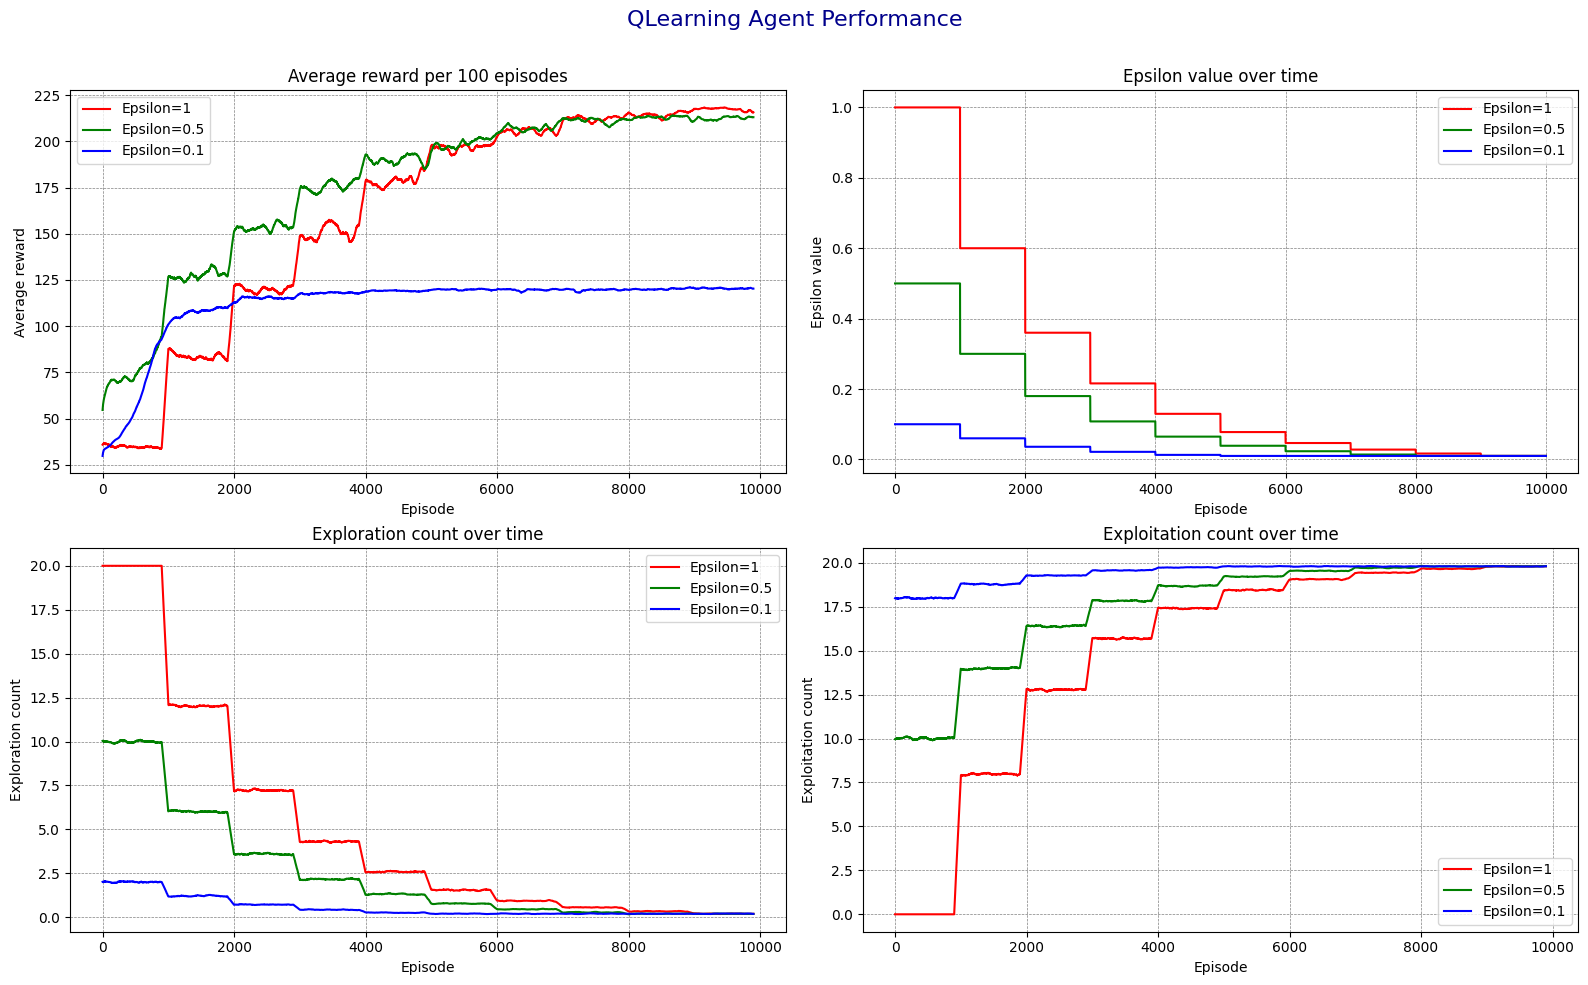

In [8]:
number_of_runs = 30

env = GridWorld()
epsilon_values = [1, 0.5, 0.1]
avg_agent_rewards, avg_epsilon_over_time, avg_exploration_over_time, avg_exploitation_over_time, all_q_values_statistics, all_agent_q_values = train_agents(env, number_of_episodes=10000, agent_class=QLearningAgent, number_of_runs=number_of_runs, epsilon_values=epsilon_values)
plot_results(avg_agent_rewards, avg_epsilon_over_time, avg_exploration_over_time, avg_exploitation_over_time, epsilon_values)

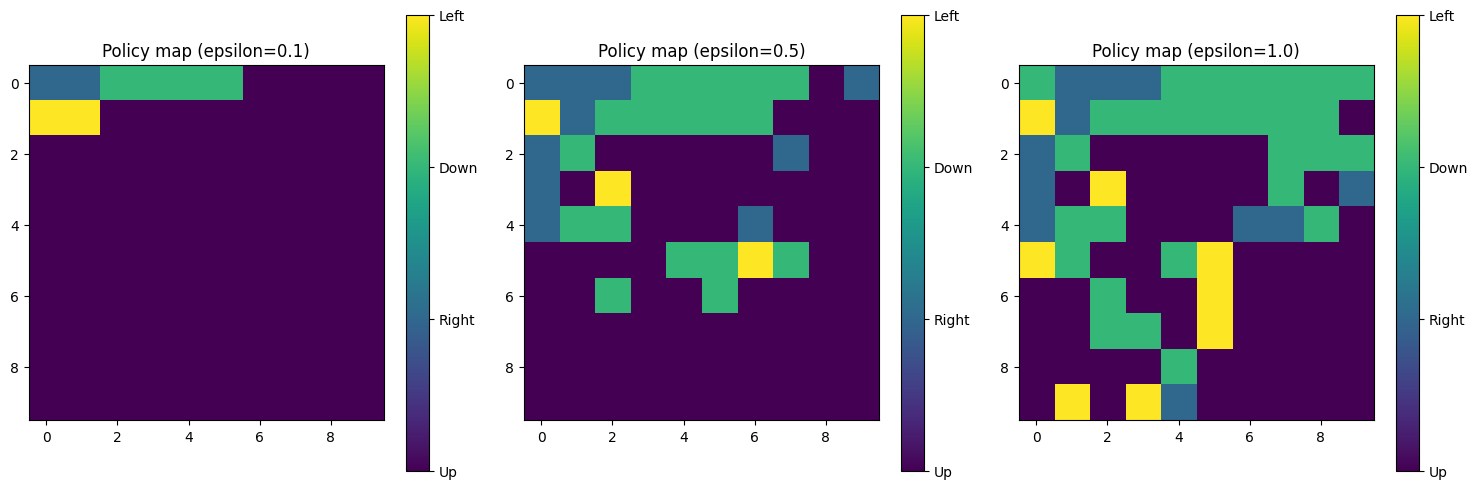

In [9]:
df_grouped = convert_to_df(all_agent_q_values, epsilon_values)
plot_policy_map(df_grouped)
# this is a policy map for only one agent which is stating from 0,0

In [10]:
all_q_values_statistics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[{'mean': 92.98222385856036,
   'median': 30.74148421188306,
   'mode': 0,
   'variance': 10750.724812231498,
   'standard_deviation': 103.68570206268315,
   'interquartile_range': 209.1169039229429,
   'skewness': 0.5352453336671988,
   'kurtosis': -1.4440371936675325},
  {'mean': 96.34343632594275,
   'median': 107.99131895085672,
   'mode': 0,
   'variance': 7845.955372336111,
   'standard_deviation': 88.57739763808887,
   'interquartile_range': 183.6829700035005,
   'skewness': 0.00415598035317948,
   'kurtosis': -1.8661338352612977},
  {'mean': 85.93981943228522,
   'median': 117.23470595302655,
   'mode': 0,
   'variance': 2525.700905741655,
   'standard_deviation': 50.25635189447852,
   'interquartile_range': 89.21061372262261,
   'skewness': -0.9664648745278491,
   'kurtosis': -0.9536503669170253}],
 [{'mean': 87.12601338609151,
   'median': 17.862047261535192,
   'mode': 0,
   'variance': 10245.649595709607,
   'standard_deviation': 101.22079626099375,
   'interquartile_range

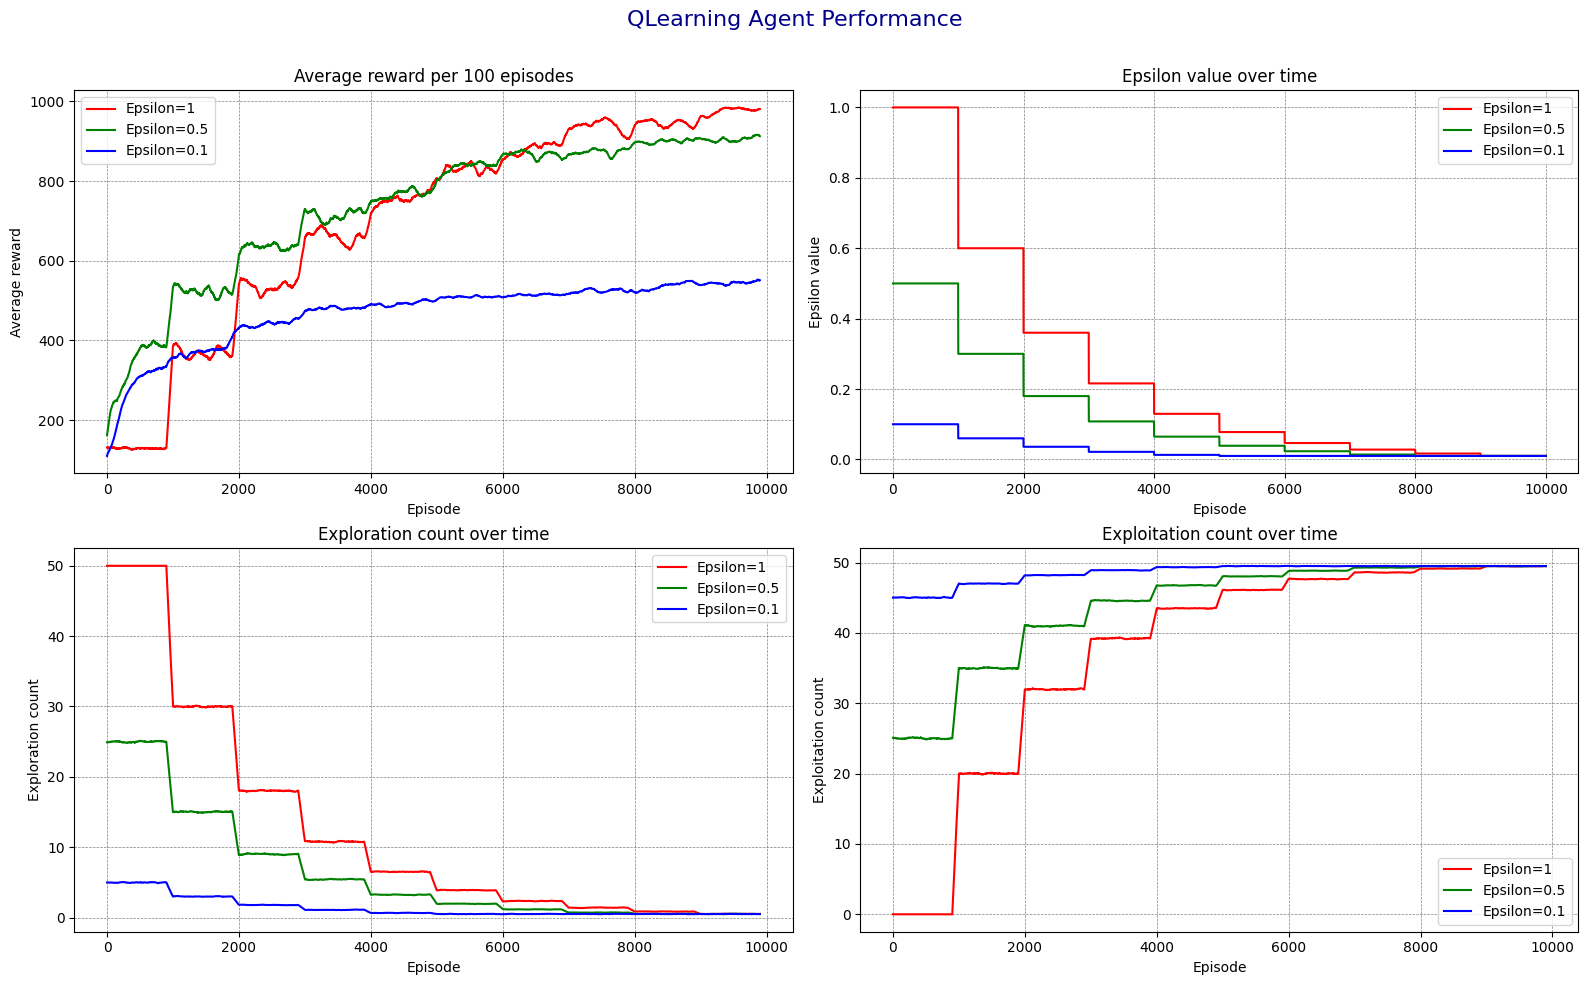

In [11]:
number_of_runs = 30

env = GridWorld2()
epsilon_values2 = [1, 0.5, 0.1]
avg_agent_rewards2, avg_epsilon_over_time2, avg_exploration_over_time2, avg_exploitation_over_time2, all_q_values_statistics2, all_agent_q_values2 = train_agents(env, number_of_episodes=10000, agent_class=QLearningAgent, number_of_runs=number_of_runs, epsilon_values=epsilon_values)
plot_results(avg_agent_rewards2, avg_epsilon_over_time2, avg_exploration_over_time2, avg_exploitation_over_time2, epsilon_values2)

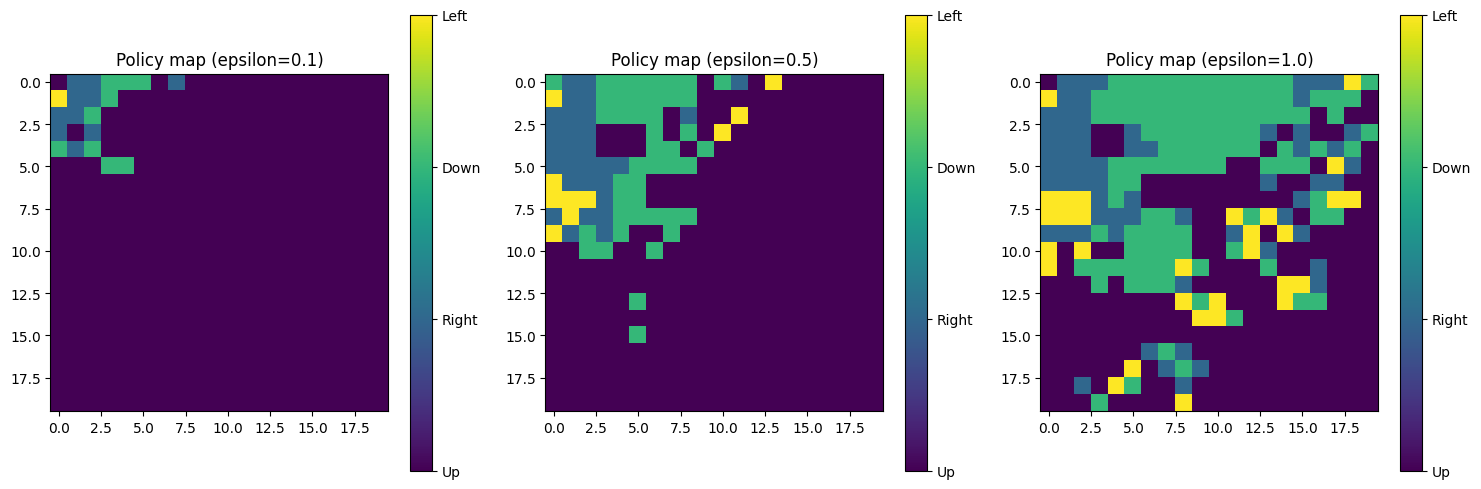

In [12]:
df_grouped2 = convert_to_df(all_agent_q_values2, epsilon_values2)
plot_policy_map(df_grouped2,grid_size=(20, 20))
# this is a policy map for only one agent which is stating from 0,0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


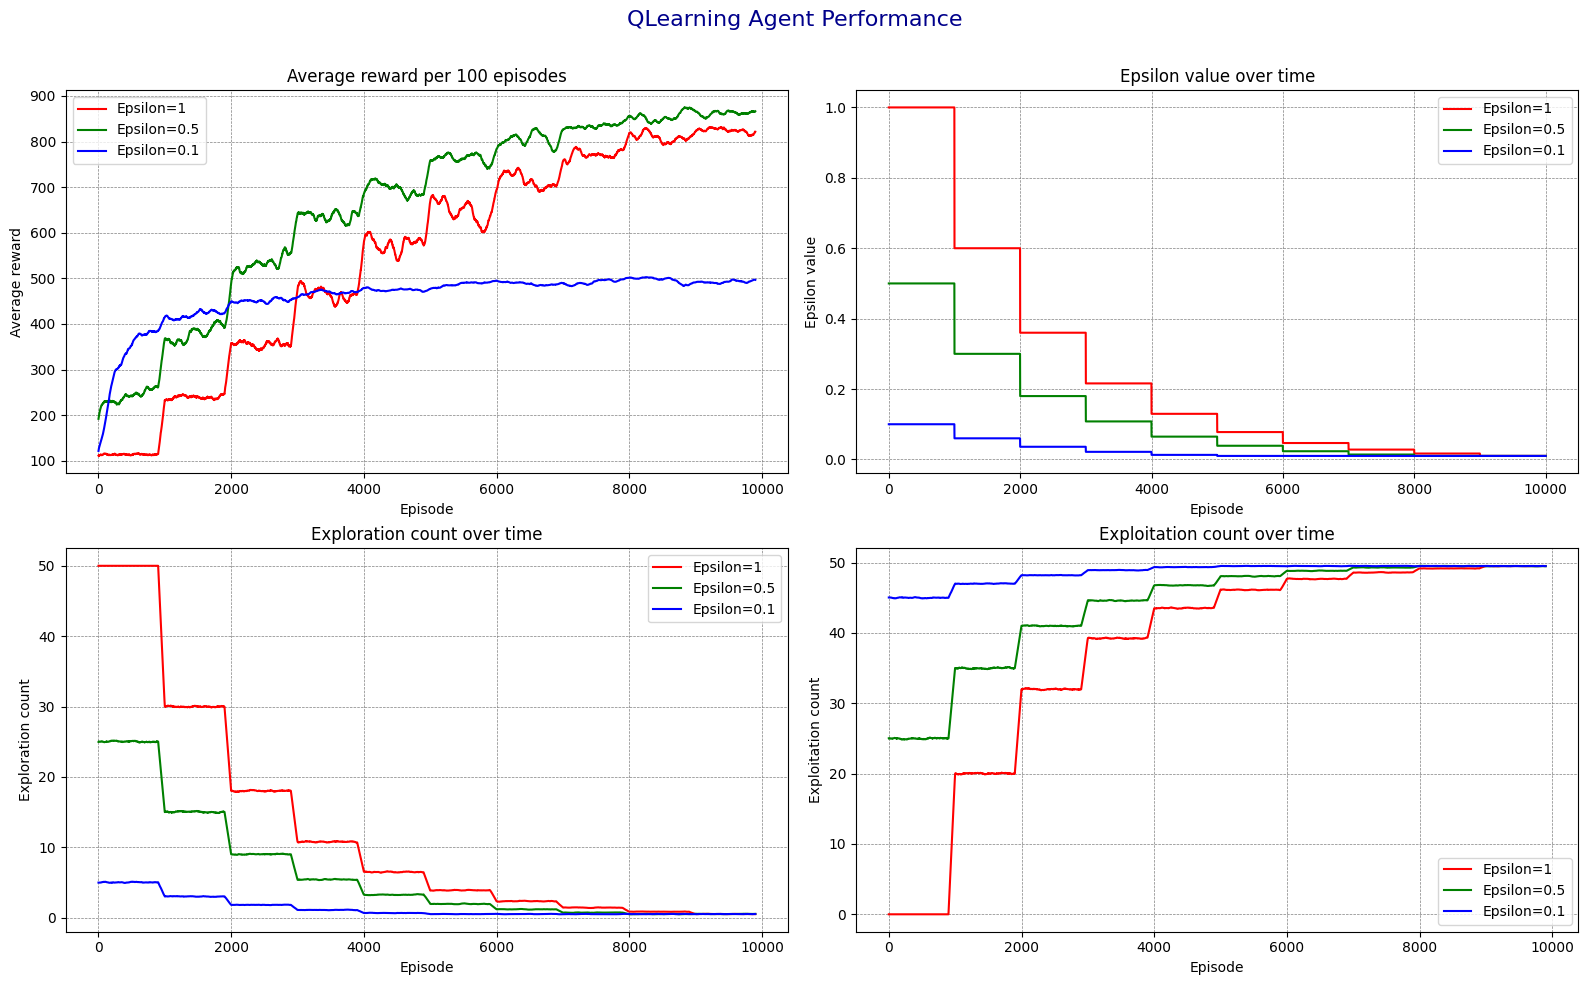

In [13]:
number_of_runs = 30

env = GridWorld3()
epsilon_values3 = [1, 0.5, 0.1]
avg_agent_rewards3, avg_epsilon_over_time3, avg_exploration_over_time3, avg_exploitation_over_time3, all_q_values_statistics3, all_agent_q_values3 = train_agents(env, number_of_episodes=10000, agent_class=QLearningAgent, number_of_runs=number_of_runs, epsilon_values=epsilon_values)
plot_results(avg_agent_rewards3, avg_epsilon_over_time3, avg_exploration_over_time3, avg_exploitation_over_time3, epsilon_values3)

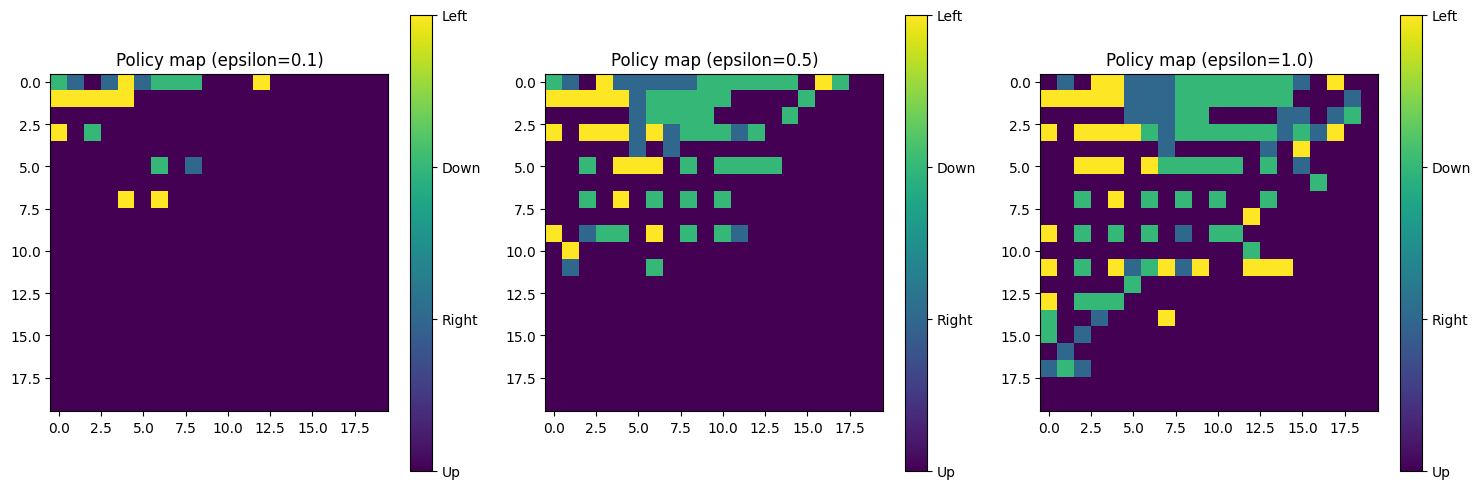

In [14]:
df_grouped3 = convert_to_df(all_agent_q_values3, epsilon_values3)
plot_policy_map(df_grouped3, grid_size=(20, 20))
# this is a policy map for only one agent which is stating from 0,0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
